<h1 align="center"> Image Captioning (8 points) </h1>

In this notebook you will teach a network to do image captioning
![img](https://i.imgur.com/obITaMl.png)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [0]:
# Please either download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.ipynb

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/Colab Notebooks/dataset

%ls

/content/gdrive/My Drive/Colab Notebooks/dataset
handout.tar.gz


In [11]:
!tar xvzf handout.tar.gz

data/
data/captions_tokenized.json
data/image_codes.npy


In [10]:
!ls

GoogleNews-vectors-negative300.bin.gz  handout.tar.gz
handout.tar			       Train_rev1.zip


### Data preprocessing

In [12]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 204 ms, sys: 997 ms, total: 1.2 s
Wall time: 1.59 s


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [13]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [0]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [0]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure
for img_i in captions:
    for caption_i in img_i:
        word_counts.update(caption_i)

In [0]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [0]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [18]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [0]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens,emb_size,padding_idx=pad_ix)
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size,lstm_units,batch_first=True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.lin1 = nn.Linear(lstm_units, lstm_units*8)
        self.dropout = nn.Dropout(0.5)
        self.logits = nn.Linear(8*lstm_units,n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg
        
        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out,_ = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
        # compute logits from lstm_out
        logits = self.logits(self.dropout(F.relu(self.lin1(lstm_out))))
        
        return logits        

In [0]:
network_baseline = CaptionNet(n_tokens).cuda()

In [100]:
dummy_img_vec = torch.randn(len(captions[0]), 2048).cuda()
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64).cuda()

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)
dummy_logits_base = network_baseline.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [0]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous() # без последнего
    captions_ix_next = captions_ix[:, 1:].contiguous() # без первого
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    

    loss = F.cross_entropy(logits_for_next.reshape(-1, logits_for_next.shape[-1]),captions_ix_next.reshape(-1),ignore_index=pad_ix)
    
    return loss.reshape(-1)

In [0]:
dummy_loss_baseline = compute_loss(network_baseline, dummy_img_vec, dummy_capt_ix)
assert dummy_loss_baseline.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss_baseline.data.cpu().numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss_baseline.backward()

assert all(param.grad is not None for param in network_baseline.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [0]:
opt_baseline = torch.optim.Adam(network_baseline.parameters(),lr=1e-2)

# Training

* First implement the batch generator
* Than train the network as usual

In [0]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [0]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32).cuda(), torch.tensor(batch_captions_ix, dtype=torch.int64).cuda()
    

In [29]:
generate_batch(img_codes,captions,3)

(tensor([[1.4324e-02, 5.8272e-01, 7.2385e-01,  ..., 3.1278e-01, 9.6140e-01,
          1.2735e-01],
         [9.1585e-01, 5.5808e-02, 2.4712e-01,  ..., 2.9647e-03, 1.4229e+00,
          1.3844e-03],
         [1.6256e-01, 3.0766e-01, 8.5446e-01,  ..., 9.7862e-02, 8.4392e-01,
          6.8239e-02]], device='cuda:0'),
 tensor([[   1,   24,  122, 1328,   41,  138,  127,   53,   15, 1291,   12,    2,
             3,    3,    3],
         [   1,  112,  305,  310,  311,  408,   45,  209,   18,   24,  203,  495,
          1019,   12,    2],
         [   1,   24,   57, 1203,   18,   24, 4304,  501,  183,   24,  362, 1880,
          1845,   12,    2]], device='cuda:0'))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [0]:
batch_size = 100  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 100  # adjust me
n_validation_batches = 10  # how many batches are used for validation after each epoch

In [0]:
val_stop_losses = np.arange(2,2.9,0.1)
val_stop_losses = val_stop_losses[::-1]


Epoch: 99, train loss: 2.4127221655845643, val loss: 2.4567938327789305


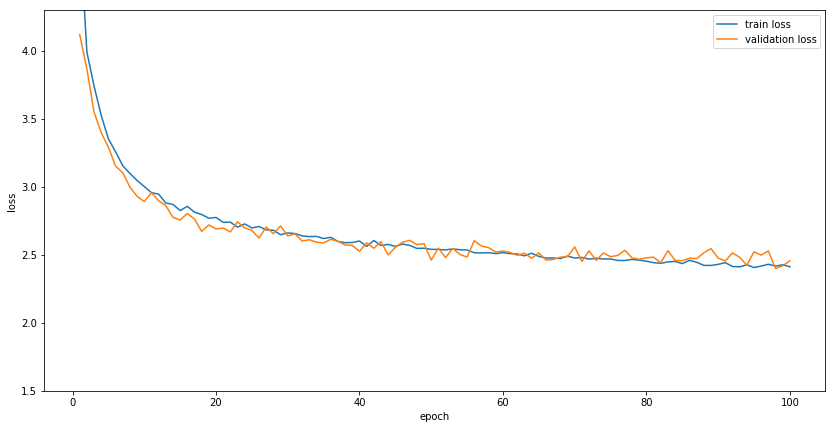







100%|██████████| 100/100 [29:25<00:00, 17.48s/it]







Finished!


In [107]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output # my
train_loss_l = []
val_loss_l = []

stop = 0

for epoch in tqdm(range(n_epochs)):
    train_loss=0
    network_baseline.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network_baseline, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt_baseline
        opt_baseline.zero_grad()
        loss_t.backward()
        opt_baseline.step()
        
        train_loss += loss_t.item()
        
    train_loss /= n_batches_per_epoch
    train_loss_l.append(train_loss)
    
    val_loss=0
    network_baseline.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network_baseline, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches
    val_loss_l.append(val_loss)
    
    clear_output(True)
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))
    plt.figure(figsize=(14, 7))
    plt.plot(np.linspace(0,epoch,epoch + 1) , train_loss_l, label = 'train loss')
    plt.plot(np.linspace(0,epoch,epoch + 1) , val_loss_l, label = 'validation loss')
    plt.ylim([1.5, 4.3])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    if val_loss <= val_stop_losses[stop]:
        name = 'network_baseline'
        name_model = name+'_'+str(val_stop_losses[stop])+'.ckpt'
        name_dict = name+'_params_'+str(val_stop_losses[stop])+'.ckpt'
        torch.save(network_baseline, name_model)
        torch.save(network_baseline.state_dict(), name_dict)
        stop+=1
        

print("Finished!")

### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [108]:
torch.save(network_baseline, 'network_baseline_last.ckpt')

# Save and load only the model parameters (recommended).
torch.save(network_baseline.state_dict(), 'network_baseline_params_last.ckpt')
# resnet.load_state_dict(torch.load('params.ckpt'))!unzip Train_rev1.zip

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CaptionNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [109]:
!ls

beheaded_inception3.py
data
GoogleNews-vectors-negative300.bin.gz
handout.tar
handout.tar.gz
img.jpg
network_2.8000000000000003.ckpt
network_2.8000000000000007.ckpt
network_baseline_2.5000000000000004.ckpt
network_baseline_2.6000000000000005.ckpt
network_baseline_2.7000000000000006.ckpt
network_baseline_2.8000000000000007.ckpt
network_baseline_params_2.5000000000000004.ckpt
network_baseline_params_2.6000000000000005.ckpt
network_baseline_params_2.7000000000000006.ckpt
network_baseline_params_2.8000000000000007.ckpt
network_last.ckpt
network_params_2.8000000000000003.ckpt
network_params_2.8000000000000007.ckpt
network_params_last.ckpt
__pycache__
Train_rev1.zip


In [0]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False).cuda()

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [0]:
def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=100,network=network_baseline):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32).cuda()

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64).cuda()
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.cpu().numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

In [113]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
import nltk.translate.bleu_score as bleu_score
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

--2019-05-16 14:01:52--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.120.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.120.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107928 (105K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 105.40K  --.-KB/s    in 0.02s   

2019-05-16 14:01:52 (6.58 MB/s) - ‘img.jpg’ saved [107928/107928]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  if __name__ == '__main__':


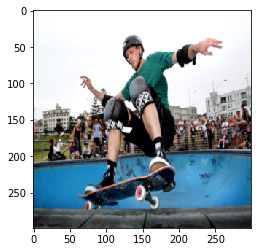

In [114]:
plt.imshow(img)

In [115]:
bl_score = []
for i in range(10):
    bl_score.append(generate_caption(img, t=5.)[1:-1])
    print(' '.join(bl_score[-1]))
bleu_score.sentence_bleu(bl_score[:-1],bl_score[-1])

a person riding a skateboard on a ramp .
a man riding a skateboard on top of a ramp .
a man on a skateboard in the air .
a man riding a skateboard on top of a cement ramp .
a man riding a skateboard up the side of a ramp .
a man riding a skateboard up the side of a ramp .
a man riding a skateboard down a ramp .
a man is riding a skateboard on a ramp .
a man in a helmet riding a skateboard .
a man riding a skateboard on top of a ramp .


1.0

--2019-05-16 14:02:16--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 23.185.0.2, 2620:12a:8001::2, 2620:12a:8000::2
Connecting to ccanimalclinic.com (ccanimalclinic.com)|23.185.0.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104.37K  --.-KB/s    in 0.01s   

2019-05-16 14:02:16 (6.87 MB/s) - ‘data/img.jpg’ saved [106870/106870]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


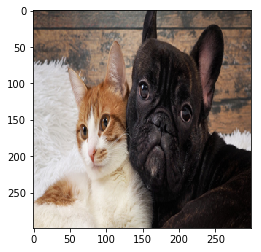

a cat sitting on a couch with a dog .
a black and white cat sitting on a couch .
a cat sitting on a couch with a dog .
a black and white cat sitting on a couch .
a cat sitting on a chair in a room .
a black and white cat sitting on a couch .
a black and white cat is laying on a bed .
a cat sitting on a bed with a stuffed animal .
a cat is sitting on a couch with a dog .
a cat sitting on a couch with a teddy bear .


In [116]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()
bl_score = []
for i in range(10):
    bl_score.append(generate_caption(img, t=5.)[1:-1])
    print(' '.join(bl_score[-1]))

In [119]:
bleu_score.sentence_bleu(bl_score[1:],bl_score[0])

1.0

# Demo
### Find at least 10 images to test it on.

* Seriously, that's a part of the assignment. Go get at least 10 pictures for captioning
* Make sure it works okay on __simple__ images before going to something more complex
* Your pictures must feature both successful and failed captioning. Get creative :)
* Use photos, not animation/3d/drawings, unless you want to re-train CNN network on anime
* Mind the aspect ratio.

In [174]:
!wget https://avatars.mds.yandex.net/get-pdb/1016500/13074d6e-7f96-4ce6-85f1-70631e6d769c/orig -O data/img1.jpg
img1 = plt.imread('data/img1.jpg')
img1 = imresize(img1, (299, 299)).astype('float32') / 255.

!wget https://www.meme-arsenal.com/memes/d0b202e06c98f8dd0569236ae83d3ad6.jpg -O data/img2.jpg
img2 = plt.imread('data/img2.jpg')
img2 = imresize(img2, (299, 299)).astype('float32') / 255.

!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/K%C5%91szeg_-_july_2007.jpg/1200px-K%C5%91szeg_-_july_2007.jpg -O data/img3.jpg
img3 = plt.imread('data/img3.jpg')
img3 = imresize(img3, (299, 299)).astype('float32') / 255.

!wget https://www.tacno.net/wp-content/uploads/2015/11/Puppy_love.jpg -O data/img4.jpg
img4 = plt.imread('data/img4.jpg')
img4 = imresize(img4, (299, 299)).astype('float32') / 255.

!wget https://www.guidedogs.org/wp-content/uploads/2018/01/Mobile.jpg -O data/img5.jpg
img5 = plt.imread('data/img5.jpg')
img5 = imresize(img5, (299, 299)).astype('float32') / 255.

!wget https://timedotcom.files.wordpress.com/2014/12/ap1109280145869.jpg -O data/img6.jpg
img6 = plt.imread('data/img6.jpg')
img6 = imresize(img6, (299, 299)).astype('float32') / 255.

!wget https://townsquare.media/site/295/files/2014/08/The-Beatles-Abbey-Road.jpg -O data/img7.jpg
img7 = plt.imread('data/img7.jpg')
img7 = imresize(img7, (299, 299)).astype('float32') / 255.

!wget https://i.pinimg.com/originals/d8/07/4b/d8074ba3cfba11d5e76ed24a7ac6d624.png -O data/img8.jpg
img8 = plt.imread('data/img8.jpg')
img8 = imresize(img8, (299, 299)).astype('float32') / 255.


!wget https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSubLECTZT0hsFMjR1S2LQWmWWgxdZTL5tP_g0E_q69gvfGYNAb -O data/img9.jpg
img9 = plt.imread('data/img9.jpg')
img9 = imresize(img9, (299, 299)).astype('float32') / 255.

!wget https://img8.eadaily.com/r650x400/o/7f8/16975933b5a0b3fec65c4e22451dd.jpg -O data/img10.jpg
img10 = plt.imread('data/img10.jpg')
img10 = imresize(img10, (299, 299)).astype('float32') / 255.

!wget https://i.ytimg.com/vi/7lyYBDDbP2A/maxresdefault.jpg -O data/img11.jpg
img11 = plt.imread('data/img11.jpg')
img11 = imresize(img11, (299, 299)).astype('float32') / 255.


--2019-05-16 15:00:27--  https://avatars.mds.yandex.net/get-pdb/1016500/13074d6e-7f96-4ce6-85f1-70631e6d769c/orig
Resolving avatars.mds.yandex.net (avatars.mds.yandex.net)... 87.250.247.182, 87.250.247.183, 87.250.247.184, ...
Connecting to avatars.mds.yandex.net (avatars.mds.yandex.net)|87.250.247.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 660024 (645K) [image/jpeg]
Saving to: ‘data/img1.jpg’

data/img1.jpg       100%[===================>] 644.55K  2.76MB/s    in 0.2s    

2019-05-16 15:00:27 (2.76 MB/s) - ‘data/img1.jpg’ saved [660024/660024]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


--2019-05-16 15:00:29--  https://www.meme-arsenal.com/memes/d0b202e06c98f8dd0569236ae83d3ad6.jpg
Resolving www.meme-arsenal.com (www.meme-arsenal.com)... 82.146.63.105
Connecting to www.meme-arsenal.com (www.meme-arsenal.com)|82.146.63.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51766 (51K) [image/jpeg]
Saving to: ‘data/img2.jpg’

data/img2.jpg       100%[===================>]  50.55K  --.-KB/s    in 0.04s   

2019-05-16 15:00:30 (1.11 MB/s) - ‘data/img2.jpg’ saved [51766/51766]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  import sys


--2019-05-16 15:00:33--  https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/K%C5%91szeg_-_july_2007.jpg/1200px-K%C5%91szeg_-_july_2007.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 269754 (263K) [image/jpeg]
Saving to: ‘data/img3.jpg’

data/img3.jpg       100%[===================>] 263.43K  --.-KB/s    in 0.02s   

2019-05-16 15:00:33 (11.8 MB/s) - ‘data/img3.jpg’ saved [269754/269754]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  # This is added back by InteractiveShellApp.init_path()


--2019-05-16 15:00:36--  https://www.tacno.net/wp-content/uploads/2015/11/Puppy_love.jpg
Resolving www.tacno.net (www.tacno.net)... 104.18.41.250, 104.18.40.250, 2606:4700:30::6812:29fa, ...
Connecting to www.tacno.net (www.tacno.net)|104.18.41.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75902 (74K) [image/jpeg]
Saving to: ‘data/img4.jpg’

data/img4.jpg       100%[===================>]  74.12K  --.-KB/s    in 0.008s  

2019-05-16 15:00:36 (9.16 MB/s) - ‘data/img4.jpg’ saved [75902/75902]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  from ipykernel import kernelapp as app


--2019-05-16 15:00:39--  https://www.guidedogs.org/wp-content/uploads/2018/01/Mobile.jpg
Resolving www.guidedogs.org (www.guidedogs.org)... 192.138.21.222
Connecting to www.guidedogs.org (www.guidedogs.org)|192.138.21.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5867546 (5.6M) [image/jpeg]
Saving to: ‘data/img5.jpg’

data/img5.jpg       100%[===================>]   5.60M  2.23MB/s    in 2.5s    

2019-05-16 15:00:42 (2.23 MB/s) - ‘data/img5.jpg’ saved [5867546/5867546]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


--2019-05-16 15:00:44--  https://timedotcom.files.wordpress.com/2014/12/ap1109280145869.jpg
Resolving timedotcom.files.wordpress.com (timedotcom.files.wordpress.com)... 192.0.72.2
Connecting to timedotcom.files.wordpress.com (timedotcom.files.wordpress.com)|192.0.72.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276526 (270K) [image/jpeg]
Saving to: ‘data/img6.jpg’

data/img6.jpg       100%[===================>] 270.04K  --.-KB/s    in 0.02s   

2019-05-16 15:00:44 (15.4 MB/s) - ‘data/img6.jpg’ saved [276526/276526]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


--2019-05-16 15:00:47--  https://townsquare.media/site/295/files/2014/08/The-Beatles-Abbey-Road.jpg
Resolving townsquare.media (townsquare.media)... 152.195.39.166
Connecting to townsquare.media (townsquare.media)|152.195.39.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 183362 (179K) [image/jpeg]
Saving to: ‘data/img7.jpg’

data/img7.jpg       100%[===================>] 179.06K  --.-KB/s    in 0.01s   

2019-05-16 15:00:47 (15.4 MB/s) - ‘data/img7.jpg’ saved [183362/183362]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


--2019-05-16 15:00:50--  https://i.pinimg.com/originals/d8/07/4b/d8074ba3cfba11d5e76ed24a7ac6d624.png
Resolving i.pinimg.com (i.pinimg.com)... 151.101.120.84, 2a04:4e42:1d::84
Connecting to i.pinimg.com (i.pinimg.com)|151.101.120.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 442731 (432K) [image/png]
Saving to: ‘data/img8.jpg’

data/img8.jpg       100%[===================>] 432.35K  --.-KB/s    in 0.03s   

2019-05-16 15:00:50 (16.6 MB/s) - ‘data/img8.jpg’ saved [442731/442731]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


--2019-05-16 15:00:53--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSubLECTZT0hsFMjR1S2LQWmWWgxdZTL5tP_g0E_q69gvfGYNAb
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 74.125.140.102, 74.125.140.139, 74.125.140.113, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|74.125.140.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4124 (4.0K) [image/jpeg]
Saving to: ‘data/img9.jpg’

data/img9.jpg       100%[===================>]   4.03K  --.-KB/s    in 0s      

2019-05-16 15:00:53 (8.98 MB/s) - ‘data/img9.jpg’ saved [4124/4124]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


--2019-05-16 15:00:56--  https://img8.eadaily.com/r650x400/o/7f8/16975933b5a0b3fec65c4e22451dd.jpg
Resolving img8.eadaily.com (img8.eadaily.com)... 148.251.176.244
Connecting to img8.eadaily.com (img8.eadaily.com)|148.251.176.244|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66800 (65K) [image/jpeg]
Saving to: ‘data/img10.jpg’

data/img10.jpg      100%[===================>]  65.23K  --.-KB/s    in 0.02s   

2019-05-16 15:00:56 (3.62 MB/s) - ‘data/img10.jpg’ saved [66800/66800]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


--2019-05-16 15:00:59--  https://i.ytimg.com/vi/7lyYBDDbP2A/maxresdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 74.125.140.119, 66.102.1.119, 108.177.15.119, ...
Connecting to i.ytimg.com (i.ytimg.com)|74.125.140.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84098 (82K) [image/jpeg]
Saving to: ‘data/img11.jpg’

data/img11.jpg      100%[===================>]  82.13K  --.-KB/s    in 0.01s   

2019-05-16 15:00:59 (8.06 MB/s) - ‘data/img11.jpg’ saved [84098/84098]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


In [0]:
def model_with_image(model,img):
    plt.imshow(img)
    plt.show()

    bl_score = []
    for i in range(10):
        bl_score.append(generate_caption(img, t=5.)[1:-1])
        print(' '.join(bl_score[-1]))
    print(bleu_score.sentence_bleu(bl_score[:-1],bl_score[-1]))

**For final baseline model**

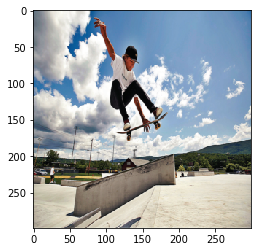

a skateboarder is doing a trick on a ramp .
a man riding a skateboard down a ramp .
a man jumping in the air on a skateboard .
a man riding a skateboard on top of a ramp .
a man is doing a trick on a skateboard .
a man riding a skateboard on top of a ramp .
a man on a skateboard doing a trick .
a man riding a skateboard down a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard down a ramp .
1.0


In [140]:
model_with_image(model=network_baseline,img=img1)

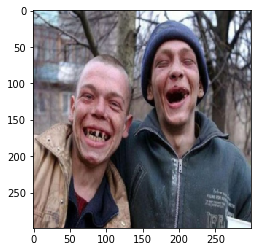

a man in a suit and tie standing next to a woman .
a man in a suit and tie standing next to a man .
a man and woman standing in a room with a man in the background .
a man and a woman are posing for a picture .
a man and a woman are holding a cell phone .
a man and a woman are posing for a picture .
a man and a woman are standing in a room .
a man and a woman are posing for a picture .
a man in a suit and tie standing in front of a building .
a man wearing a tie and a tie .
0.5317273507662637


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [130]:
model_with_image(model=network_baseline,img=img2)

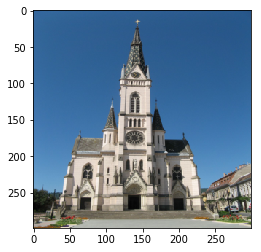

a clock tower with a clock on it .
a clock tower with a clock on it
a clock tower with a clock tower on top of it .
a clock tower with a clock on top .
a clock tower with a clock on it .
a large clock tower with a clock on it .
a large clock tower with a clock on the top .
a clock tower with a clock on it .
a large clock tower with a clock on top .
a clock tower with a clock on the side of it .
0.7348889200874658


In [131]:
model_with_image(model=network_baseline,img=img3)

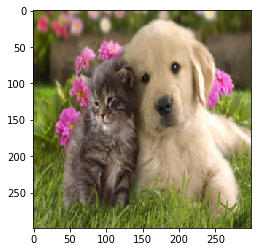

a dog is laying on a bed with a red blanket .
a dog is laying on a bed with a blanket .
a brown dog is sitting on a couch .
a dog is laying on a couch with a dog .
a dog is laying on a bed with a dog .
a brown dog laying on top of a bed .
a dog is laying on a bed with a stuffed animal .
a brown dog is sitting on a couch with a teddy bear .
a dog is sitting on a couch with a dog .
a dog is laying on a couch with a dog .
1.0


In [132]:
model_with_image(model=network_baseline,img=img4)

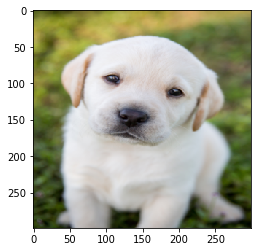

a dog is sitting on a couch with a frisbee .
a dog is sitting on a chair in front of a window .
a dog is sitting on a chair in front of a window .
a dog is sitting on a chair in front of a mirror .
a dog is laying on a couch with a frisbee .
a dog is sitting on a chair with a frisbee in its mouth .
a dog is sitting on a couch with a frisbee in his mouth .
a dog is sitting on a chair in the grass .
a dog is laying on a bed with a frisbee .
a dog is sitting on a chair in the snow .
0.8070557274927981


In [133]:
model_with_image(model=network_baseline,img=img5)

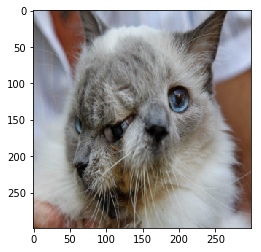

a cat sitting on a chair in front of a mirror .
a cat sitting on a chair in a room .
a cat is sitting on a bed with a cat .
a cat is sitting on a table with a cat on it .
a cat sitting on top of a wooden table .
a cat sitting on top of a wooden table .
a black and white cat sitting on a chair .
a cat sitting on a chair in a room .
a cat sitting on a table with a cat on it .
a cat sitting on a window sill looking at the camera .
0.33180774028439425


In [134]:
model_with_image(model=network_baseline,img=img6)

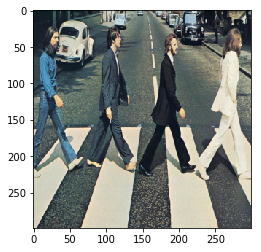

a man and a woman standing next to each other .
a group of people standing on a tennis court .
a man is standing in the middle of a street .
a man standing next to a woman on a skateboard .
a group of people standing on a tennis court .
a group of people standing on a tennis court .
a group of people standing on a sidewalk next to each other .
a group of people standing on top of a cement covered slope .
a group of people standing on a tennis court .
a group of people standing on a tennis court .
1.0


In [135]:
model_with_image(model=network_baseline,img=img7)

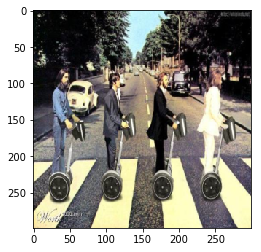

a man and woman standing next to each other .
a man and woman standing next to a truck .
a man in a suit and tie standing next to a bike .
a man and a woman standing next to a parked motorcycle .
a man and a woman standing next to each other .
a man and woman standing next to each other .
a man and woman standing on a sidewalk next to a building .
a man and woman standing next to each other .
a man and woman are standing next to each other .
a man and a woman are standing in a field .
0.5156626918239822


In [136]:
model_with_image(model=network_baseline,img=img8)

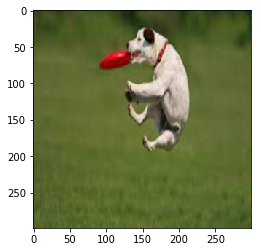

a black and white dog is jumping in the air .
a dog is jumping in the air catching a frisbee .
a dog is jumping in the air with a frisbee .
a dog is jumping in the air catching a frisbee .
a black and white dog is jumping in the air .
a dog is jumping in the air catching a frisbee .
a dog is jumping in the air catching a frisbee .
a dog is jumping in the air catching a frisbee .
a dog is jumping in the air catching a frisbee .
a dog is jumping in the air catching a frisbee .
1.0


In [137]:
model_with_image(model=network_baseline,img=img9)

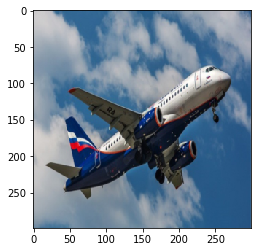

a large jetliner flying through a cloudy sky .
a large jetliner flying through a cloudy sky .
a large jetliner flying through a cloudy sky .
a large jetliner flying through a blue sky .
a large jetliner flying through a cloudy sky .
a large jetliner flying through a cloudy sky .
a large jetliner flying through a cloudy sky .
a large jetliner flying through a cloudy sky .
a large jetliner flying through a cloudy sky .
a large jetliner flying through a cloudy sky .
1.0


In [138]:
model_with_image(model=network_baseline,img=img10)

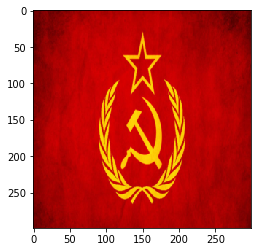

a stop sign with a bunch of stickers on it
a stop sign with a sign on it .
a stop sign with a sky background and a sign .
a stop sign with a sign on it .
a stop sign with a sign on it .
a stop sign with a red and white sign on it .
a stop sign with a sign on it .
a stop sign with a red and white sign on it .
a stop sign that is on the side of a mountain .
a stop sign with a sky background and a street sign .
0.7691605673134586


In [139]:
model_with_image(model=network_baseline,img=img11)

**For baseline model with val 2.6**

In [144]:
network_26 = torch.load('./network_baseline_2.6000000000000005.ckpt')
network_26.load_state_dict(torch.load('./network_baseline_params_2.6000000000000005.ckpt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

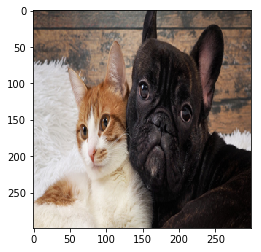

a cat that is laying down on a couch .
a cat is sitting on a couch next to a teddy bear .
a black and white cat sitting on a chair .
a black and white cat is sitting on a chair .
a black and white cat sitting on a couch .
a black and white cat sitting on a couch .
a cat is sitting on a couch with a frisbee .
a cat is sitting on a couch with a dog .
a cat sitting on a couch with a teddy bear .
a cat sitting on a couch with a dog on the floor
0.7102992180127422


In [146]:
model_with_image(model=network_26,img=img)

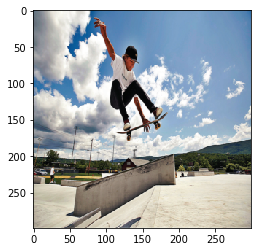

a man riding a skateboard up the side of a ramp .
a man doing a trick on a skateboard .
a man riding a skateboard on top of a ramp .
a man riding a skateboard on top of a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard on top of a ramp .
a man riding a skateboard on top of a ramp .
a man on a skateboard doing a trick
a man riding a skateboard up the side of a ramp .
1.0


In [145]:
model_with_image(model=network_26,img=img1)

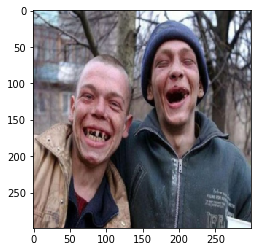

a man in a suit and tie standing next to a man .
a man and a woman are standing in a room .
a man in a suit and tie standing next to a woman .
a man in a suit and tie standing next to a woman .
a man and a woman standing next to each other .
a man and a woman are standing in a room .
a man in a suit and tie standing next to a woman .
a man and a woman are standing together .
a man in a suit and tie standing next to a woman .
a man wearing a tie and a tie in a crowd of people .
0.6026080978557137


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [147]:
model_with_image(model=network_26,img=img2)

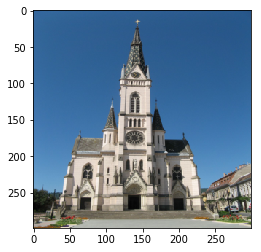

a large clock tower with a clock on it .
a clock tower with a clock on the top .
a clock tower with a clock on top of it .
a large clock tower with a clock on it .
a clock tower with a clock on top .
a clock tower with a clock on top of it .
a clock tower with a clock on the front of it .
a clock tower with a clock on it .
a clock tower with a clock on top .
a tall clock tower with a clock on the side of it .
0.5923033072023249


In [148]:
model_with_image(model=network_26,img=img3)

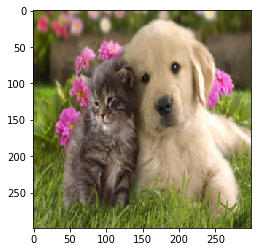

a dog is laying on a bed with a dog .
a dog is laying on a bed with a stuffed animal .
a dog is sitting on a couch with a dog .
a dog is sitting on a couch with a dog .
a dog is laying on a couch with a dog .
a dog laying on a bed with a stuffed animal .
a dog is laying on a bed with a dog .
a brown dog laying on top of a green field .
a dog is laying on a couch with a dog .
a dog is sitting on a couch with a dog .
1.0


In [152]:
model_with_image(model=network_26,img=img4)

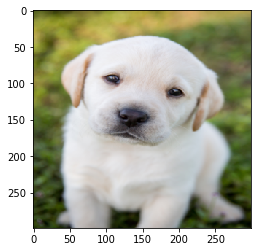

a dog is sitting on a bench with a frisbee in its mouth .
a dog is sitting on a chair with a frisbee .
a dog is sitting on a bed with a frisbee .
a dog is sitting on a chair in front of a window .
a dog is sitting on a chair in a room .
a dog is sitting on a couch with a frisbee .
a dog is sitting on a chair in a room .
a dog is sitting on a chair with a frisbee in its mouth .
a dog is sitting on a chair with a frisbee .
a dog is sitting on a chair with a frisbee .
1.0


In [153]:
model_with_image(model=network_26,img=img5)

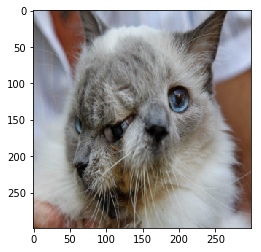

a cat sitting on top of a table next to a window .
a cat sitting on a chair in front of a mirror .
a cat sitting on top of a bed .
a cat is sitting on a chair in a room .
a cat sitting on a chair in a room .
a cat is sitting on a table with a large knife .
a cat is sitting on a table with a clock .
a cat is sitting on a table with a cat on it .
a cat is sitting on a chair in a room .
a cat is sitting on a chair in a room .
1.0


In [154]:
model_with_image(model=network_26,img=img6)

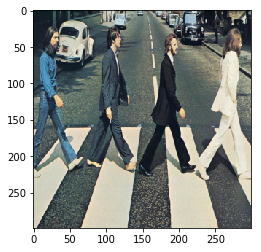

a man and a woman are standing on a tennis court .
a group of people standing on a tennis court .
a group of people standing around a skateboard .
a group of people standing next to each other .
a group of people standing on a tennis court .
a man standing next to a woman in a black and white photo .
a group of people standing around a man in a suit .
a group of people standing around a tennis court .
a group of people standing on a tennis court .
a group of people standing on a tennis court .
1.0


In [155]:
model_with_image(model=network_26,img=img7)

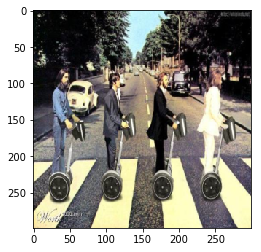

a man and a woman are standing in a row of bikes .
a man and woman standing next to a man on a motorcycle .
a man and woman standing next to a woman in a white shirt .
a man and a woman standing next to a fire hydrant .
a man and a woman are standing in the street .
a man and a woman are standing in a parking lot .
a man is riding a bike in a parking lot .
a man and a woman standing next to each other .
a man in a suit is standing next to a bike .
a man and a woman are standing next to a bike .
0.9146912192286945


In [156]:
model_with_image(model=network_26,img=img8)

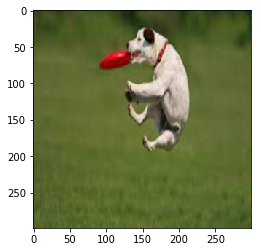

a dog is jumping in the air with a frisbee .
a dog is jumping in the air catching a frisbee .
a dog is jumping in the air catching a frisbee .
a small dog is jumping in the air .
a cat is jumping in the air with a frisbee .
a dog is jumping in the air catching a frisbee .
a small dog is jumping in the air .
a dog is jumping in the air catching a frisbee .
a dog is jumping in the air catching a frisbee .
a cat is jumping in the air with a frisbee .
1.0


In [157]:
model_with_image(model=network_26,img=img9)

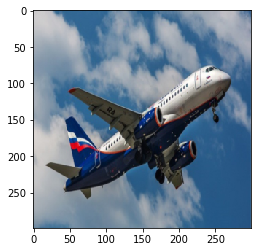

a large jetliner flying through a cloudy sky .
a large jetliner flying through a cloudy sky .
a large passenger jet flying through the air .
a large jetliner flying through a cloudy sky .
a large passenger plane flying in the sky .
a large jetliner flying through a cloudy sky .
a large jetliner flying through a cloudy sky .
a large plane flying in the sky with a sky background
a large jetliner flying through a cloudy sky .
a large jetliner flying through a cloudy sky .
1.0


In [158]:
model_with_image(model=network_26,img=img10)

**model with val=2.7**

In [159]:
network_27 = torch.load('./network_baseline_2.7000000000000006.ckpt')
network_27.load_state_dict(torch.load('./network_baseline_params_2.7000000000000006.ckpt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

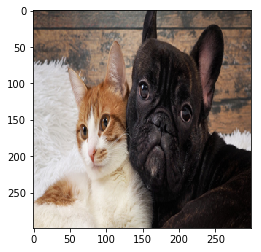

a black and white cat sitting on a couch .
a cat sitting on a couch with a stuffed animal .
a black and white cat sitting on a chair .
a black and white cat sitting on a couch .
a cat sitting on a chair with a frisbee in its mouth .
a cat sitting on a couch with a teddy bear on it .
a black and white cat is sitting on a couch .
a cat that is sitting on a couch .
a cat sitting on a couch in a room .
a cat is laying on a couch with a dog .
0.4497332084013506


In [162]:
model_with_image(model=network_27,img=img)

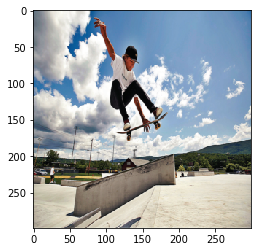

a man riding a skateboard on top of a ramp .
a man riding a skateboard on top of a cement ramp .
a man riding a skateboard on top of a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard on a ramp .
a man on a skateboard does a trick
a man riding a skateboard on top of a cement ramp .
a man on a skateboard doing a trick .
a man riding a skateboard down a ramp .
a man riding a skateboard on top of a ramp .
1.0


In [161]:
model_with_image(model=network_27,img=img1)

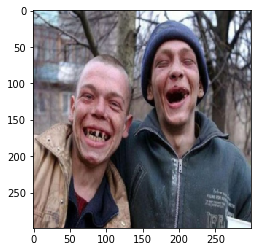

a man and a woman standing next to each other .
a man and a woman are posing for a picture .
a man in a suit and tie standing in front of a building .
a man in a suit and tie is standing next to a woman .
a man and a woman sitting in a chair .
a man and a woman standing next to each other .
a man and a woman are posing for a picture .
a man and a woman are posing for a picture .
a man with a tie and a tie on his face .
a man in a suit and tie standing in front of a building .
1.0


In [163]:
model_with_image(model=network_27,img=img2)

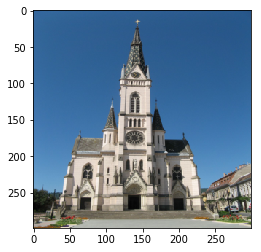

a large clock tower with a clock on it .
a clock tower with a clock on the top .
a large clock tower with a clock on top .
a clock tower with a clock on the side of it .
a clock tower with a clock on top .
a clock tower with a clock on top of it .
a clock tower with a clock on top of it .
a large clock tower with a clock on it .
a clock tower with a clock on it .
a large clock tower with a clock on the side of it .
1.0


In [164]:
model_with_image(model=network_27,img=img3)

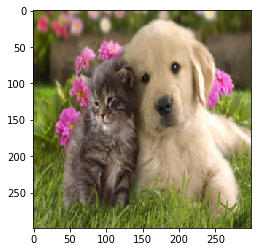

a dog is laying on a couch with a dog .
a dog is laying on a bed with a dog .
a dog is laying on a couch with a frisbee .
a dog is laying on a couch with a dog .
a dog is sitting on a bed with a dog .
a dog is sitting on a couch with a dog .
a dog is sitting on a couch with a dog .
a dog is laying on a couch with a dog .
a dog is sitting on a couch with a dog .
a dog is laying on a bed with a dog .
1.0


In [165]:
model_with_image(model=network_27,img=img4)

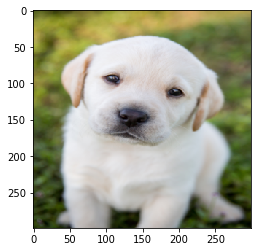

a dog sitting on a couch with a frisbee in its mouth .
a dog is sitting on a chair in a living room .
a dog laying on a couch with a frisbee in its mouth .
a dog is sitting on a couch with a frisbee .
a dog is sitting on a chair in front of a window .
a dog is standing on a couch with a frisbee in his mouth .
a dog is sitting on a table with a frisbee .
a dog that is sitting on a couch .
a dog is sitting on a couch with a frisbee .
a dog is sitting on a chair in a room .
0.8512160931922469


In [166]:
model_with_image(model=network_27,img=img5)

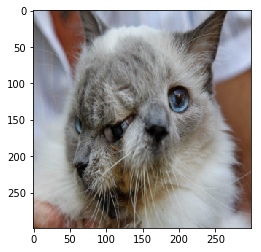

a cat is sitting in a window sill .
a cat is sitting on a couch with a camera in the background .
a cat is sitting on a chair in a room .
a cat sitting on top of a chair .
a cat sitting on a chair in a room .
a cat is sitting on a table with a teddy bear .
a cat sitting on a shelf with a mirror .
a cat is sitting on a chair in a room .
a cat is sitting on a table with a camera .
a cat is sitting on a couch in a room .
0.8132882808488929


In [167]:
model_with_image(model=network_27,img=img6)

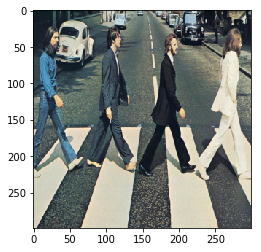

a group of people standing on a sidewalk next to each other .
a man and a woman standing on a tennis court .
a man standing on a skateboard in a skate park .
a group of people standing on a tennis court .
a group of people standing on a tennis court .
a group of people standing on the side of a road .
a group of people standing on a tennis court .
a man and a woman standing on a tennis court .
a man standing on a skateboard in a room .
a group of people standing on top of a cement court .
0.5156626918239822


In [168]:
model_with_image(model=network_27,img=img7)

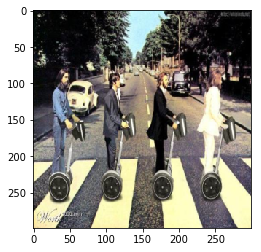

a man standing next to a man on a skateboard .
a group of people standing next to each other .
a man and a woman are standing in a row .
a man and a woman are standing next to a motorcycle .
a man in a black shirt and a hat on a bike
a man is standing in front of a building .
a man and a woman are standing in a row .
a man standing next to a woman on a skateboard .
a man and a woman are standing in the street .
a group of people standing next to each other .
1.0


In [169]:
model_with_image(model=network_27,img=img8)

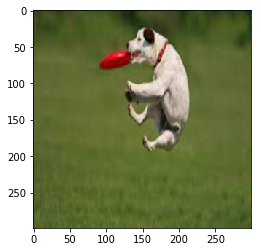

a dog is jumping in the air catching a frisbee .
a dog is jumping in the air catching a frisbee .
a dog is jumping in the air catching a frisbee .
a dog is jumping in the air with a frisbee .
a dog is jumping in the air catching a frisbee .
a dog is jumping in the air catching a frisbee .
a dog is jumping in the air catching a frisbee .
a dog is jumping in the air catching a frisbee .
a dog is jumping in the air to catch a frisbee .
a dog is jumping in the air catching a frisbee .
1.0


In [172]:
model_with_image(model=network_27,img=img9)

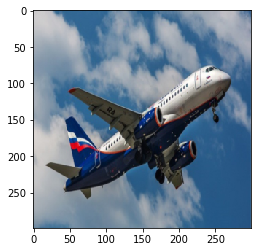

a large jetliner flying through a cloudy sky .
a large plane flying in the sky .
a large jetliner flying through a cloudy sky .
a large jetliner flying through a cloudy sky .
a large jetliner flying through a cloudy sky .
a large jetliner flying through a cloudy sky .
a large jetliner flying through a cloudy sky .
a large jetliner flying through a cloudy sky .
a plane flying in the sky over a mountain range .
a large jetliner flying through a cloudy sky .
1.0


In [173]:
model_with_image(model=network_27,img=img10)

**For baseline model with val=2.8**

In [175]:
network_28 = torch.load('./network_baseline_2.8000000000000007.ckpt')
network_28.load_state_dict(torch.load('./network_baseline_params_2.8000000000000007.ckpt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

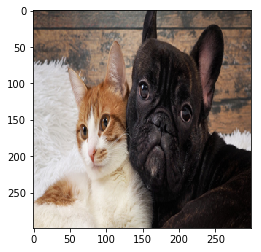

a black and white cat sitting on a chair .
a black and white cat sitting on a couch .
a cat is sitting on a couch next to a chair .
a cat sitting on a couch with a teddy bear .
a cat sitting on a couch with a teddy bear .
a black and white cat sitting on a couch .
a cat laying on a couch with a dog
a cat sitting on a couch with a cat on it .
a black and white cat sitting on a couch .
a black and white cat laying on a couch .
0.8891397050194614


In [178]:
model_with_image(model=network_28,img=img)

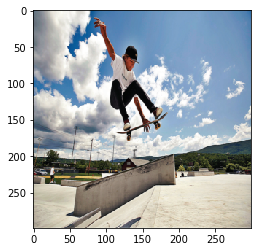

a man riding a skateboard on top of a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard on top of a ramp .
a man riding a skateboard up the side of a ramp .
a man doing a trick on a skateboard .
a man riding a skateboard on top of a ramp .
a skateboarder is doing a trick on a ramp .
a man riding a skateboard on top of a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard up the side of a ramp .
1.0


In [180]:
model_with_image(model=network_28,img=img1)

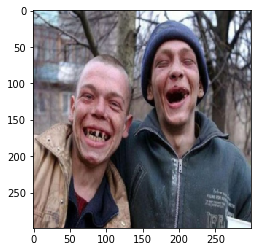

a man in a suit and tie standing next to a woman .
a man and a woman are posing for a picture .
a man in a suit and tie standing next to a woman .
a man in a suit and tie standing in front of a building .
a man and a woman are posing for a picture .
a man in a suit and tie standing next to a woman .
a man in a suit and tie standing next to a man .
a man and a woman standing next to each other .
a man in a suit and tie standing next to a man .
a man and a woman are posing for a picture .
1.0


In [181]:
model_with_image(model=network_28,img=img2)

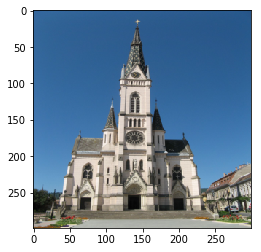

a clock tower with a clock on top of it .
a clock tower with a clock on top of it .
a clock tower with a clock on top .
a clock tower with a clock on top .
a clock tower with a clock on top of it .
a tall clock tower with a clock on the top .
a tall clock tower with a clock on it .
a clock tower with a clock on the top .
a clock tower with a clock on the top .
a clock tower with a clock on top .
1.0


In [182]:
model_with_image(model=network_28,img=img3)

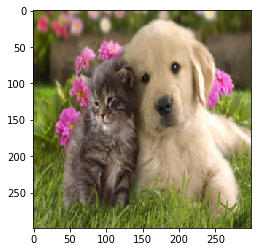

a dog is sitting on a couch with a dog .
a dog is sitting on a chair with a dog .
a black dog is laying on a bed with a dog .
a dog is sitting on a couch with a dog .
a dog is sitting on a bed with a stuffed animal .
a dog is sitting on a couch in a room .
a dog is sitting on a chair in the grass .
a dog is on a leash with a dog on the ground .
a dog is standing on a bed with a stuffed animal .
a dog is sitting on a couch with a frisbee .
0.8070557274927981


In [183]:
model_with_image(model=network_28,img=img4)

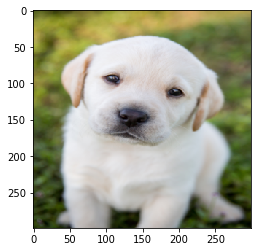

a dog is sitting on a chair in a room .
a dog is sitting on a couch with a frisbee .
a dog is sitting on a wooden bench .
a dog is laying on a bed with a white blanket .
a dog is sitting on a chair in a room .
a dog laying on a bed with a frisbee in his mouth .
a dog is sitting on a bench with a frisbee .
a dog is sitting on a chair in front of a mirror .
a dog is sitting on a chair in a room .
a dog is sitting on a couch with a frisbee .
1.0


In [185]:
model_with_image(model=network_28,img=img5)

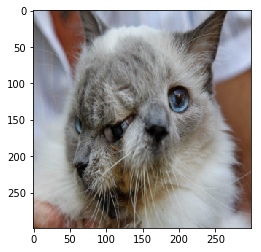

a cat is sitting on a chair in front of a mirror .
a cat is sitting on a chair in a room .
a cat sitting on top of a bed .
a cat sitting on a chair in a room .
a cat sitting on a couch with a clock on it .
a cat sitting on top of a table next to a window .
a cat sitting on a chair in front of a mirror .
a cat is sitting on a chair in a room .
a cat sitting on a bed with a laptop .
a cat sitting on a chair in front of a mirror .
1.0


In [186]:
model_with_image(model=network_28,img=img6)

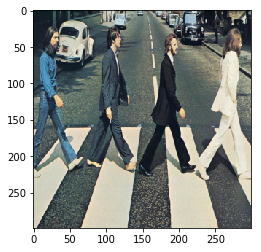

a man in a white shirt and tie standing on a sidewalk .
a group of people standing on a sidewalk next to each other .
a group of people standing on a tennis court .
a man and a woman standing on a tennis court .
a man in a suit and tie walking down a street .
a group of people standing on a tennis court .
a group of people standing next to each other .
a man in a suit and tie standing in front of a building .
a man standing on a skateboard in a parking lot .
a man and a woman standing next to each other .
0.9036020036098449


In [187]:
model_with_image(model=network_28,img=img7)

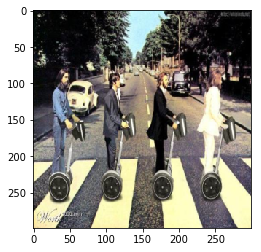

a group of people standing around a large truck .
a man is standing on a bench with a dog .
a man and a woman are standing in a row of motorcycles .
a man and a woman standing next to a parked motorcycle .
a man and woman standing in front of a building .
a man and woman standing next to a man on a skateboard .
a man and a woman standing next to a white truck .
a man and a woman are standing next to a motorcycle .
a man and a woman are standing in a parking lot .
a man and a woman standing next to each other .
0.6989307622784944


In [188]:
model_with_image(model=network_28,img=img8)

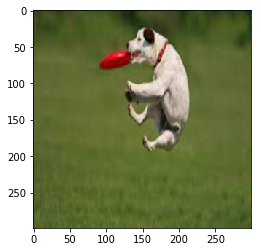

a dog is jumping in the air to catch a frisbee .
a dog is jumping in the air catching a frisbee .
a dog is jumping in the air catching a frisbee .
a cat is jumping in the air with a frisbee .
a cat is jumping in the air with a frisbee .
a black and white dog is jumping in the air .
a dog is jumping in the air catching a frisbee .
a dog is jumping in the air with a frisbee in its mouth .
a dog is jumping in the air catching a frisbee .
a dog is jumping in the air catching a frisbee .
1.0


In [190]:
model_with_image(model=network_28,img=img9)

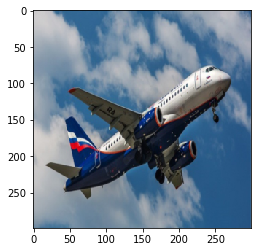

a large jetliner flying through a cloudy sky .
a large jetliner flying through a cloudy sky .
a large jetliner flying through a cloudy sky .
a large jetliner flying through a cloudy sky .
a large jetliner flying through a cloudy sky .
a large jetliner flying through a cloudy sky .
a large jetliner flying through a cloudy sky .
a large jetliner flying through a cloudy sky .
a large jetliner flying through a cloudy sky .
a large jetliner flying through a cloudy sky .
1.0


In [191]:
model_with_image(model=network_28,img=img10)

Good hunting!
![img](https://cs7.pikabu.ru/images/big_size_comm_an/2018-09_3/1536865148163644198.gif)

As you can see for some pictures better models with low val loss (for example: your picture withdog and cat, beatles, img4) but model overfits for img5 (with help of many dogs with freesbe) 